In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from textblob import TextBlob

# disable altair limit
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [2]:
# load complaints data
data = pd.read_csv('complaints.csv')

data.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-08-23,"Payday loan, title loan, or personal loan",Installment loan,Problem when making payments,NaN,NaN,NaN,OneMain Finance Corporation,NC,27407,NaN,NaN,Web,2023-08-23,Closed with explanation,Yes,NaN,7448359
1,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,GA,30318,NaN,Consent not provided,Web,2023-08-23,Closed with non-monetary relief,Yes,NaN,7442747
2,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"Maximus Education, LLC dba Aidvantage",OH,43035,Servicemember,NaN,Web,2023-08-23,Closed with explanation,Yes,NaN,7442667
3,2023-08-23,Credit card or prepaid card,Store credit card,Fees or interest,Charged too much interest,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",KY,41018,Older American,NaN,Phone,2023-08-23,Closed with explanation,Yes,NaN,7442765
4,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,FORD MOTOR CREDIT CO.,FL,336XX,NaN,NaN,Web,2023-08-23,In progress,Yes,NaN,7448366


In [3]:
print(data.shape)

data.info()

(4028530, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028530 entries, 0 to 4028529
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memo

Missing values percentage

In [4]:
# check for missing values percentage

data.isnull().sum()/len(data)


Date received                   0.000000
Product                         0.000000
Sub-product                     0.058406
Issue                           0.000000
Sub-issue                       0.177570
Consumer complaint narrative    0.637554
Company public response         0.538235
Company                         0.000000
State                           0.010704
ZIP code                        0.007499
Tags                            0.895048
Consumer consent provided?      0.222613
Submitted via                   0.000000
Date sent to company            0.000000
Company response to consumer    0.000001
Timely response?                0.000000
Consumer disputed?              0.809271
Complaint ID                    0.000000
dtype: float64

Missing values percentage by year

In [5]:
# add a column for year, 
# missing values percentage by column and by year

data['year'] = pd.DatetimeIndex(data['Date received']).year

# transpose the table to get a better view, store it in a new dataframe

data_year = data.groupby('year').apply(lambda x: x.isnull().sum()/len(x)).T

data_year


year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Date received,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Product,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sub-product,0.496845,0.238020,0.255778,0.293559,0.315560,0.348470,0.099731,0.000058,0.000047,0.000034,0.000103,0.000034,0.000000
Issue,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sub-issue,1.000000,0.973982,0.763674,0.525397,0.534102,0.516204,0.239707,0.138887,0.124984,0.088916,0.093214,0.056405,0.038081
Consumer complaint narrative,1.000000,1.000000,1.000000,1.000000,0.675007,0.593541,0.525980,0.539551,0.549708,0.607596,0.589528,0.578688,0.688139
Company public response,1.000000,0.999972,0.999917,0.999131,0.633726,0.479627,0.519182,0.495718,0.480696,0.431368,0.598439,0.426376,0.512120
Company,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
State,0.005915,0.008498,0.009731,0.006542,0.006791,0.006932,0.016351,0.029107,0.028471,0.018199,0.011631,0.002481,0.003404
ZIP code,0.005126,0.006853,0.007670,0.003993,0.004464,0.004430,0.013049,0.025550,0.025168,0.016153,0.005028,0.000217,0.000114


Get sample three rows

In [6]:
# sample 3 rows from the data , and print it out as dictionary

sample_3_rows = data.sample(3).to_dict(orient='records')

sample_3_rows



[{'Date received': '2022-09-24',
  'Product': 'Credit reporting, credit repair services, or other personal consumer reports',
  'Sub-product': 'Credit reporting',
  'Issue': 'Improper use of your report',
  'Sub-issue': 'Reporting company used your report improperly',
  'Consumer complaint narrative': nan,
  'Company public response': 'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
  'Company': 'Experian Information Solutions Inc.',
  'State': 'AZ',
  'ZIP code': '85044',
  'Tags': nan,
  'Consumer consent provided?': 'Consent not provided',
  'Submitted via': 'Web',
  'Date sent to company': '2022-09-24',
  'Company response to consumer': 'Closed with non-monetary relief',
  'Timely response?': 'Yes',
  'Consumer disputed?': nan,
  'Complaint ID': 6015566,
  'year': 2022},
 {'Date received': '2021-02-08',
  'Product': 'Credit reporting, credit repair services, or other personal consumer reports',
  'Sub-product': 'Credit reporting',
 

Number of unique values in each column

In [7]:
# check unique values in each column, and print it out as dictionary

n_unique = data.nunique().to_dict()

n_unique


{'Date received': 4295,
 'Product': 21,
 'Sub-product': 81,
 'Issue': 172,
 'Sub-issue': 248,
 'Consumer complaint narrative': 1239244,
 'Company public response': 11,
 'Company': 6909,
 'State': 63,
 'ZIP code': 33059,
 'Tags': 3,
 'Consumer consent provided?': 4,
 'Submitted via': 7,
 'Date sent to company': 4244,
 'Company response to consumer': 8,
 'Timely response?': 2,
 'Consumer disputed?': 2,
 'Complaint ID': 4028530,
 'year': 13}

date received min and max range


In [8]:

# astype date received and date sent to company to datetime

data['Date received'] = pd.to_datetime(data['Date received'])

data['Date sent to company'] = pd.to_datetime(data['Date sent to company'])

print("data time range: ", data['Date received'].min().date(), data['Date received'].max().date())



data time range:  2011-12-01 2023-09-05


data volume by year

In [9]:
# data volume by year

print(data['Date received'].dt.year.value_counts().sort_index())



# Perform the value counts and sorting
value_counts = data['Date received'].dt.year.value_counts().sort_index().reset_index()
value_counts.columns = ['Year', 'Count']

# Create the Altair chart
alt.Chart(value_counts).mark_bar().encode(
    x='Year:O',
    y='Count:Q'
).properties(
    title='Yearly Counts of Date received'
)


2011      2536
2012     72372
2013    108215
2014    153012
2015    168453
2016    191434
2017    242863
2018    257223
2019    277300
2020    444305
2021    496009
2022    800388
2023    814420
Name: Date received, dtype: int64


alt.Chart(...)

In [10]:
# date volume by month, and plot it

print(data['Date received'].dt.month.value_counts().sort_index())


# Perform the value counts and sorting
monthly_counts = data['Date received'].dt.month.value_counts().sort_index().reset_index()
monthly_counts.columns = ['Month', 'Count']

# Create the Altair chart
chart = alt.Chart(monthly_counts).mark_bar().encode(
    x='Month:O',
    y='Count:Q'
).properties(
    title='Monthly Counts of Date received'
)

chart

1     331687
2     310090
3     370081
4     367098
5     367518
6     370924
7     386280
8     385153
9     281018
10    288642
11    273148
12    296891
Name: Date received, dtype: int64


alt.Chart(...)

number of missing 'consumer disputed?' by year

2011      2536
2012     72372
2013    108215
2014    153012
2015    168453
2016    191434
2017     72336
Name: Date received, dtype: int64


<AxesSubplot: >

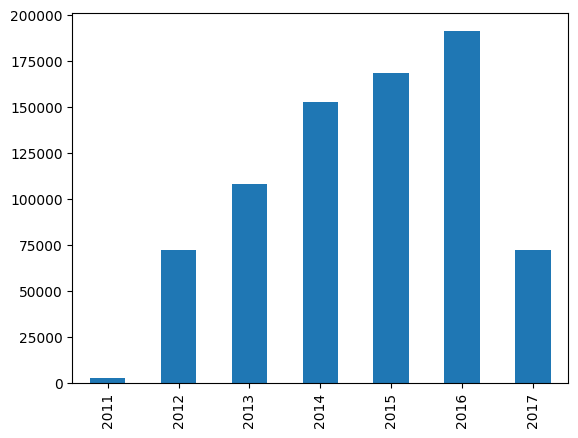

In [11]:
# number of non missing 'consumer disputed?' by year, print actual values and plot it

print(data[data['Consumer disputed?'].notnull()]['Date received'].dt.year.value_counts().sort_index())

data[data['Consumer disputed?'].notnull()]['Date received'].dt.year.value_counts().sort_index().plot(kind='bar')

In [12]:
# product values

data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    2162845
Debt collection                                                                  503401
Mortgage                                                                         383137
Credit card or prepaid card                                                      205725
Checking or savings account                                                      180437
Credit reporting                                                                 140429
Credit card                                                                       89569
Bank account or service                                                           86205
Student loan                                                                      76153
Money transfer, virtual currency, or money service                                58142
Vehicle loan or lease                                                             47080
Consumer Loan                   

In [13]:
# value counts for sub product

data['Sub-product'].value_counts()

Credit reporting                                    2158991
Checking account                                     202775
General-purpose credit card or charge card           158765
I do not know                                        112161
Other debt                                            99597
                                                     ...   
Rental debt                                              23
Electronic Benefit Transfer / EBT card                   12
Mortgage modification or foreclosure avoidance            2
Money order, traveler's check or cashier's check          1
Student loan debt relief                                  1
Name: Sub-product, Length: 81, dtype: int64

In [14]:
# issue value counts

data['Issue'].value_counts().head(100)

Incorrect information on your report                                                1043871
Problem with a credit reporting company's investigation into an existing problem     589095
Improper use of your report                                                          517504
Attempts to collect debt not owed                                                    180328
Loan modification,collection,foreclosure                                             112306
                                                                                     ...   
Shopping for a loan or lease                                                           2029
Getting a line of credit                                                               1875
Unsolicited issuance of credit card                                                    1853
Credit reporting                                                                       1696
Getting a loan                                                                  

In [15]:
# sub issue value counts

data['Sub-issue'].value_counts().head(20)

Information belongs to someone else                                                 684258
Reporting company used your report improperly                                       345906
Their investigation did not fix an error on your report                             335088
Credit inquiries on your report that you don't recognize                            168185
Investigation took more than 30 days                                                132968
Account information incorrect                                                       118075
Account status incorrect                                                            117125
Was not notified of investigation status or results                                  95609
Debt is not yours                                                                    91180
Personal information incorrect                                                       63449
Didn't receive enough information to verify debt                                     55180

In [16]:
# customer complaint narrative value counts

data['Consumer complaint narrative'].sample(20)

74988      I asked for my credit report from Equifax on X...
823518                                                   NaN
2060594                                                  NaN
3033341    XX/XX/XXXX - Spoke with XXXX, the office of th...
1306450                                                  NaN
3495846    In accordance with the Fair Credit Reporting a...
432294     This particular account situation that is late...
222484     When I originally opened my Children's Place c...
1715542    I've sent the credit Bureaus letters to verify...
331406     Date XXXX XXXX Name XXXX XXXX XXXX XXXX XXXX X...
2317412                                                  NaN
1465287    According to my credit report dated XXXX/XXXX/...
1442526    I co-signed on an auto loan for my ex-husband ...
621203     I attempted to call AMEX customer service via ...
875412     Hi I am submitting this XXXX XXXX this isn't a...
3376271                                                  NaN
870374     I was contact

In [17]:
# replace XX ... XXXXX ..  so forth in customer complaint narrative with empty string

data['Consumer complaint narrative'] = data['Consumer complaint narrative'].str.replace(r'X{2,}', '', regex=True)

In [18]:
data['Consumer complaint narrative'].sample(20)

2145140                                                  NaN
1899650                                                  NaN
3086584                                                  NaN
1980736                                                  NaN
3504609    ( This complaint is being generated by the con...
2415578                                                  NaN
2108638    opened a new Lowes home improvement store card...
2881132                                                  NaN
3340892                                                  NaN
227823          , NY  ;     , NY        {$0.00} ;     Bal...
1782884                                                  NaN
1428314    My credit report contains information to be ex...
695539                                                   NaN
3112227                                                  NaN
3216488                                                  NaN
1595928                                                  NaN
850502     CFPB CASE    

In [19]:
# company public response value counts

data['Company public response'].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            1632907
Company believes it acted appropriately as authorized by contract or law                                                    126657
Company chooses not to provide a public response                                                                             52473
Company believes the complaint is the result of a misunderstanding                                                           12312
Company disputes the facts presented in the complaint                                                                        10035
Company believes complaint caused principally by actions of third party outside the control or direction of the company       7509
Company believes complaint is the result of an isolated error                                                                 6068
Company believes complaint represents an opportunity for improvement to better serv

In [20]:
# Company  value counts

data['Company'].value_counts()

EQUIFAX, INC.                                766683
TRANSUNION INTERMEDIATE HOLDINGS, INC.       681580
Experian Information Solutions Inc.          625425
BANK OF AMERICA, NATIONAL ASSOCIATION        131020
WELLS FARGO & COMPANY                        119147
                                              ...  
Integrity Home Mortgage and Finance, Inc.         1
O.D. REI, Inc                                     1
Allied Enrollment Centers LLC                     1
Direct Lending Group, Inc                         1
J Martinez Investments LLC                        1
Name: Company, Length: 6909, dtype: int64

In [21]:
# state value counts

data['State'].value_counts()

CA    471202
FL    464118
TX    411218
GA    267910
NY    258490
       ...  
AA        57
MP        53
AS        42
MH        33
PW        13
Name: State, Length: 63, dtype: int64

In [22]:
# zip code value counts

data['ZIP code'].value_counts()

XXXXX    100549
30349      7164
35405      5616
19143      5341
33025      5144
          ...  
25444         1
83425         1
91570         1
27233         1
13679         1
Name: ZIP code, Length: 33059, dtype: int64

In [23]:
# tags value counts

data['Tags'].value_counts()


Servicemember                    244428
Older American                   143587
Older American, Servicemember     34786
Name: Tags, dtype: int64

In [24]:
# consumer consent provided value counts

data['Consumer consent provided?'].value_counts()

Consent not provided    1517667
Consent provided        1460821
Other                    146024
Consent withdrawn          7213
Name: Consumer consent provided?, dtype: int64

In [25]:
# submitted via value counts

data['Submitted via'].value_counts()

Web             3503766
Referral         242366
Phone            164988
Postal mail       90089
Fax               25658
Web Referral       1238
Email               425
Name: Submitted via, dtype: int64

In [26]:
# Company response to consumer value counts

data['Company response to consumer'].value_counts()

Closed with explanation            2934815
Closed with non-monetary relief     795130
Closed with monetary relief         137963
In progress                         110474
Closed without relief                17868
Closed                               17611
Untimely response                     9360
Closed with relief                    5304
Name: Company response to consumer, dtype: int64

In [27]:
# Timely response? value counts

data['Timely response?'].value_counts()

Yes    3974796
No       53734
Name: Timely response?, dtype: int64

In [28]:
# Consumer disputed? value counts

data['Consumer disputed?'].value_counts()

No     619980
Yes    148378
Name: Consumer disputed?, dtype: int64

Some EDA.  Top 10 products by number of complaints

In [29]:


# Get top 10 products
top_products = data['Product'].value_counts().nlargest(10) 

# Get top 10 sub-products
top_subproducts = data['Sub-product'].value_counts().nlargest(10)

# Create the dataframes
data1 = pd.DataFrame({'Product': top_products.index, 
                      'Complaints': top_products.values})

data2 = pd.DataFrame({'Subproduct': top_subproducts.index, 
                      'Complaints': top_subproducts.values})

# Sort products by count
data1 = data1.sort_values('Complaints', ascending=False)

left = alt.Chart(data1).mark_bar().encode(
    y=alt.Y('Product:O', sort='-x'),
    x='Complaints'
)

# Sort sub-products by count 
data2 = data2.sort_values('Complaints', ascending=False)

right = alt.Chart(data2).mark_bar().encode(
    y=alt.Y('Subproduct:O', sort='-x'),
    x='Complaints'
)


# Display side-by-side
alt.hconcat(left, right)

alt.HConcatChart(...)

Monthly Trends of Complaints Received by a specific product (interactive)

In [30]:


# Create a dropdown selection for products
product_selection = alt.selection_single(
    name='Select',
    fields=['Product'],
    bind=alt.binding_select(options=data['Product'].unique()),

)

# Group by month and count the complaints for all products
monthly_product_grouped = data.groupby([pd.Grouper(key='Date received', freq='M'), 'Product']).size().reset_index(name='Count')

# Create the Altair chart
chart = alt.Chart(monthly_product_grouped).mark_line().encode(
    x=alt.X('Date received:T', title='Month'),
    y=alt.Y('Count:Q', title='Number of Complaints'),
    tooltip=['Date received:T', 'Count:Q'],
    color='Product:N'
).transform_filter(product_selection).properties(
    title=alt.TitleParams(text='Monthly Trends of Complaints Received', subtitle='by Product'),
    width=700,
    height=400
).add_selection(product_selection)

chart


/Users/apple/DataspellProjects/mads_dataspell/venv/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning)
/Users/apple/DataspellProjects/mads_dataspell/venv/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning)


alt.Chart(...)

Monthly Trends of Complaints Received by Products


In [33]:
# Group by month and product
monthly_product_grouped = data.groupby([data['Date received'].dt.to_period('M'), 'Product']).size().reset_index(name='Count')

# Pivot the table
pivot_monthly_product = monthly_product_grouped.pivot(index='Date received', columns='Product', values='Count').fillna(0)

# Convert Period back to datetime for plotting
pivot_monthly_product.index = pivot_monthly_product.index.to_timestamp()

# Reshape the data for Altair
pivot_monthly_product.reset_index(inplace=True)
melted_data = pd.melt(pivot_monthly_product, id_vars=['Date received'], var_name='Product', value_name='Count')

# Create the Altair chart
chart = alt.Chart(melted_data).mark_line().encode(
    x=alt.X('Date received:T', title='Month'),
    y=alt.Y('Count:Q', title='Number of Complaints'),
    color=alt.Color('Product:N', title='Product'),
    tooltip=['Date received:T', 'Product:N', 'Count:Q']
).properties(
    title='Monthly Trends of Complaints Received by Product',
    width=700,
    height=400
)

chart

alt.Chart(...)

Products with the Most Complaints

In [34]:
# Calculate product complaint counts
product_complaint_counts = data.groupby('Product').size().sort_values(ascending=False).reset_index(name='Count')

# Create the Altair chart
chart = alt.Chart(product_complaint_counts).mark_bar().encode(
    y=alt.Y('Product:N', title='Product', sort='-x'),
    x=alt.X('Count:Q', title='Number of Complaints'),
    tooltip=['Product:N', 'Count:Q']
).properties(
    title='Products with the Most Complaints',
    width=700,
    height=400
)

chart

alt.Chart(...)

In [35]:
# list of company responses

data['Company public response'].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            1632907
Company believes it acted appropriately as authorized by contract or law                                                    126657
Company chooses not to provide a public response                                                                             52473
Company believes the complaint is the result of a misunderstanding                                                           12312
Company disputes the facts presented in the complaint                                                                        10035
Company believes complaint caused principally by actions of third party outside the control or direction of the company       7509
Company believes complaint is the result of an isolated error                                                                 6068
Company believes complaint represents an opportunity for improvement to better serv

Company Responses by Product and Issue

In [36]:


# Pivot table to get counts of each company response by product and issue
response_counts = pd.pivot_table(data, values='Complaint ID',
                                 index='Product', columns='Company public response',
                                 aggfunc='count', fill_value=0)

# Convert the pivot table to a DataFrame
response_counts = response_counts.reset_index()

# Melt the DataFrame for Altair
melted_response_counts = pd.melt(response_counts, id_vars='Product',
                                 var_name='Company public response',
                                 value_name='Count')

# Plot cluster chart
chart = alt.Chart(melted_response_counts).mark_bar().encode(
    x=alt.X('Product:N', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Count:Q', stack='zero'),
    color=alt.Color('Company public response:N'),
    tooltip=['Product:N', 'Company public response:N', 'Count:Q']
).properties(
    title='Company Responses by Product and Issue'
)

chart.interactive()

# Pivot table for top 3 negative responses
negative_responses = ['Company disputes the facts presented in the complaint',
                      'Company believes complaint caused principally by actions of third party outside the control or direction of the company',
                      'Company chooses not to provide a public response']

negative_response_counts = pd.pivot_table(data[data['Company public response'].isin(negative_responses)],
                                          values='Complaint ID',
                                          index='Product', columns='Company public response',
                                          aggfunc='count',
                                          fill_value=0)

# Convert the pivot table to a DataFrame
negative_response_counts = negative_response_counts.reset_index()

# Melt the DataFrame for Altair
melted_negative_response_counts = pd.melt(negative_response_counts, id_vars='Product',
                                          var_name='Company public response',
                                          value_name='Count')

# Plot cluster chart for negative responses
chart_negative = alt.Chart(melted_negative_response_counts).mark_bar().encode(
    x=alt.X('Product:N', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Count:Q', stack='zero'),
    color=alt.Color('Company public response:N'),
    tooltip=['Product:N', 'Company public response:N', 'Count:Q']
).properties(
    title='Negative Company Responses by Product and Issue'
)

chart_negative.interactive()

# Show the charts side by side
chart | chart_negative


alt.HConcatChart(...)

Top Companies with the Most Complaints

In [37]:

# Company complaint counts
company_complaint_counts = data.groupby('Company').size().reset_index(name='Total Complaints')

# Response counts
response_counts = data.groupby('Company')['Company response to consumer'].count().reset_index(name='Response Count')

# Calculate response rate (%)
company_response_rate = pd.merge(company_complaint_counts, response_counts, on='Company')
company_response_rate['Response Rate (%)'] = (company_response_rate['Response Count'] / company_response_rate['Total Complaints']) * 100

# Timely responses
timely_responses = data[data['Timely response?'] == 'Yes'].groupby('Company').size().reset_index(name='Timely Count')

# Calculate timeliness rate (%)
company_timeliness = pd.merge(company_response_rate, timely_responses, on='Company', how='left').fillna(0)
company_timeliness['Timeliness (%)'] = (company_timeliness['Timely Count'] / company_timeliness['Total Complaints']) * 100

# Select the top N companies with the most complaints
top_n = 10
top_companies = company_complaint_counts.nlargest(top_n, 'Total Complaints')

# Plot the top companies with the most complaints
bar_chart = alt.Chart(top_companies).mark_bar().encode(
    x=alt.X('Company:N', sort='-y'),
    y=alt.Y('Total Complaints:Q'),
    color=alt.Color('Company:N', legend=None),
    tooltip=['Company:N', 'Total Complaints:Q']
).properties(
    width=600,
    height=400,
    title='Top Companies with the Most Complaints'
)

bar_chart.configure_axisX(labelAngle=-45)


alt.Chart(...)

Company Public Response

In [38]:

# Get value counts of each response
responses = data['Company public response'].value_counts().reset_index()
responses.columns = ['Company Public Response', 'Number of Complaints']

# Altair bar chart
chart = alt.Chart(responses).mark_bar().encode(
    x=alt.X('Number of Complaints:Q', title='Number of Complaints'),
    y=alt.Y('Company Public Response:N', sort='-x', title='Company Public Response'),
    tooltip=['Company Public Response:N', 'Number of Complaints:Q']
).properties(
    title='Frequency of Company Responses ',
    width=600,
    height=400
)


chart


alt.Chart(...)

'% Complaints by Product and State (Top 5 Products)'

In [39]:
# Get % of complaints by product and state
product_state = data.groupby(['State', 'Product'])['Complaint ID'].count().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1)

# Select the top 5 products
top_5_products = product_state.columns[:5].tolist()

# Filter the DataFrame to keep only the top 5 products
product_state_top_5 = product_state[top_5_products].reset_index()

# Melt the DataFrame for Altair
melted_product_state = product_state_top_5.melt(id_vars='State', var_name='Product', value_name='Percentage')

# Create an Altair bar chart for % complaints by product and state with adjusted spacing
bar_chart_percentage = alt.Chart(melted_product_state).mark_bar().encode(
    x=alt.X('Percentage:Q', title='% Complaints'),
    y=alt.Y('State:N', title='State', sort='-x', axis=alt.Axis(labelPadding=10)),
    color=alt.Color('Product:N', title='Product'),
    tooltip=['State:N', 'Product:N', alt.Tooltip('Percentage:Q', title='% Complaints', format='.2%')]
).properties(
    title='% Complaints by Product and State (Top 5 Products)',
    width=600,
    height=800
)

bar_chart_percentage


alt.Chart(...)

Most Common Company Responses to consumer 

In [40]:
 
# Analyze timely response rate
timely_response = data['Timely response?']
print(f"% Timely Responses: {timely_response.value_counts(normalize=True)['Yes']*100:.2f}%")


# Get the top 10 most frequent company responses
responses = data['Company response to consumer'].value_counts().head(10).reset_index()
responses.columns = ['Company Response', 'Number of Complaints']

# bar chart for the most common company responses
bar_chart_common_responses = alt.Chart(responses).mark_bar().encode(
    x=alt.X('Number of Complaints:Q', title='Number of Complaints'),
    y=alt.Y('Company Response:N', title='Company Response', sort='-x'),
    tooltip=['Company Response:N', 'Number of Complaints:Q']
).properties(
    title='Most Common Company Responses (Top 10)',
    width=600,
    height=400
)

bar_chart_common_responses


% Timely Responses: 98.67%


alt.Chart(...)

Disputed Rate

In [41]:


# Get frequency of disputed complaints
disputed = data['Consumer disputed?'].value_counts()

# Calculate dispute rate
total_complaints = disputed.sum()
dispute_rate = disputed['Yes'] / total_complaints

# Create a DataFrame for Altair
disputed_df = pd.DataFrame({'Dispute': ['No', 'Yes'], 'Percentage': [100 - dispute_rate * 100, dispute_rate * 100]})
# Create an Altair stacked bar chart for the consumer dispute rate
bar_chart_dispute = alt.Chart(disputed_df).mark_bar().encode(
    x=alt.X('Percentage:Q', title='% of Complaints'),
    y=alt.Y('Dispute:N', title='Consumer Disputed'),
    color=alt.Color('Dispute:N', title='Consumer Disputed', scale=alt.Scale(range=['green', 'red'])),
    tooltip=['Dispute:N', 'Percentage:Q']
).properties(
    title='Consumer Disputed Rate',
    width=400,
    height=150
)

bar_chart_dispute


alt.Chart(...)

Complaint Submission Methods

In [42]:

# Get count of each submission method
submission_counts = data['Submitted via'].value_counts().reset_index()
submission_counts.columns = ['Submission Method', 'Number of Complaints']

# Create an Altair bar chart for complaint submission methods with swapped axes and sorted y-axis
bar_chart_submission = alt.Chart(submission_counts).mark_bar().encode(
    y=alt.Y('Submission Method:N', title='Submission Method', sort=alt.EncodingSortField(field='Number of Complaints:Q', order='descending')),
    x=alt.X('Number of Complaints:Q', title='Number of Complaints'),
    tooltip=['Submission Method:N', 'Number of Complaints:Q']
).properties(
    title='Complaint Submission Methods',
    width=600,
    height=400
)

bar_chart_submission


alt.Chart(...)

Distribution of Sub-Issues within Main Issues, Distribution of Sub-Products within Main Products

In [43]:
alt.data_transformers.disable_max_rows()


# Group data by 'Product' and 'Sub-product' and count complaints
sub_product_counts = data.groupby(['Product', 'Sub-product']).size().unstack(fill_value=0).reset_index()

# Melt the DataFrame for Altair
melted_sub_product_counts = sub_product_counts.melt(id_vars='Product', var_name='Sub-product', value_name='Number of Complaints')

# Create an Altair stacked bar chart for sub-products within main products
bar_chart_sub_products = alt.Chart(melted_sub_product_counts).mark_bar().encode(
    x=alt.X('Product:N', title='Product'),
    y=alt.Y('sum(Number of Complaints):Q', title='Number of Complaints'),
    color=alt.Color('Sub-product:N', title='Sub-product'),
    tooltip=['Product:N', 'Sub-product:N', 'sum(Number of Complaints):Q']
).properties(
    title='Distribution of Sub-Products within Main Products',
    width=400,
    height=300
)

# Group data by 'Issue' and 'Sub-issue' and count complaints
sub_issue_counts = data.groupby(['Issue', 'Sub-issue']).size().unstack(fill_value=0).reset_index()

# Melt the DataFrame for Altair
melted_sub_issue_counts = sub_issue_counts.melt(id_vars='Issue', var_name='Sub-issue', value_name='Number of Complaints')

# Create an Altair stacked bar chart for sub-issues within main issues
bar_chart_sub_issues = alt.Chart(melted_sub_issue_counts).mark_bar().encode(
    x=alt.X('Issue:N', title='Issue'),
    y=alt.Y('sum(Number of Complaints):Q', title='Number of Complaints'),
    color=alt.Color('Sub-issue:N', title='Sub-issue'),
    tooltip=['Issue:N', 'Sub-issue:N', 'sum(Number of Complaints):Q']
).properties(
    title='Distribution of Sub-Issues within Main Issues',
    width=600,
    height=300
)

# Concatenate the two Altair plots horizontally
concatenated_chart = (bar_chart_sub_products | bar_chart_sub_issues)

concatenated_chart.interactive()


alt.HConcatChart(...)

Consumer disputed? by product, by response


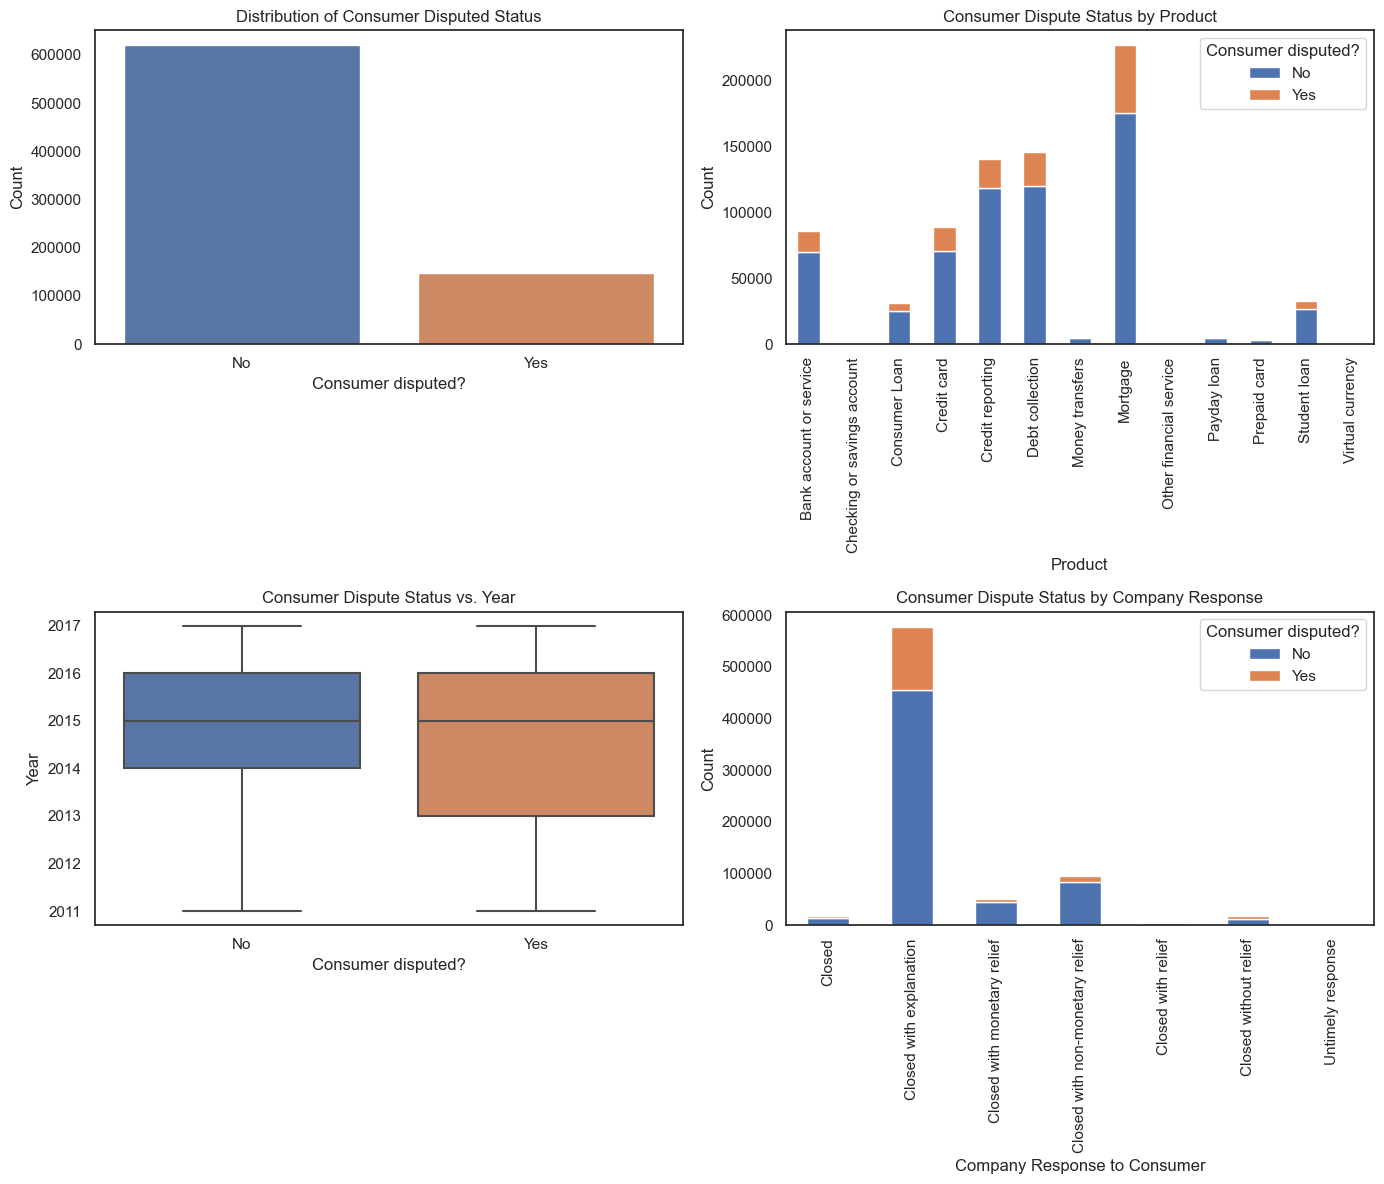

In [44]:

import seaborn as sns


# Set the style for Seaborn plots
sns.set(style='white')

# Create subplots for the individual visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Visualization 1: Countplot for 'Consumer disputed?'
sns.countplot(data=data, x='Consumer disputed?', ax=axes[0, 0])
axes[0, 0].set_xlabel('Consumer disputed?')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Consumer Disputed Status')

# Visualization 2: Stacked bar plot for 'Product' and 'Consumer disputed?'
product_dispute_crosstab = pd.crosstab(data['Product'], data['Consumer disputed?'])
product_dispute_crosstab.plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_xlabel('Product')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Consumer Dispute Status by Product')
axes[0, 1].legend(title='Consumer disputed?', loc='upper right')
axes[0, 1].tick_params(axis='x', rotation=90)

# Visualization 3: Box plot for 'Year' by dispute status
sns.boxplot(data=data, x='Consumer disputed?', y='year', ax=axes[1, 0])
axes[1, 0].set_xlabel('Consumer disputed?')
axes[1, 0].set_ylabel('Year')
axes[1, 0].set_title('Consumer Dispute Status vs. Year')

# Visualization 4: Stacked bar plot for 'Company response to consumer' and 'Consumer disputed?'
response_dispute_crosstab = pd.crosstab(data['Company response to consumer'], data['Consumer disputed?'])
response_dispute_crosstab.plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('Company Response to Consumer')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Consumer Dispute Status by Company Response')
axes[1, 1].legend(title='Consumer disputed?', loc='upper right')
axes[1, 1].tick_params(axis='x', rotation=90)

# Adjust spacing between subplots
plt.tight_layout()

# Show the concatenated visualizations
plt.show()


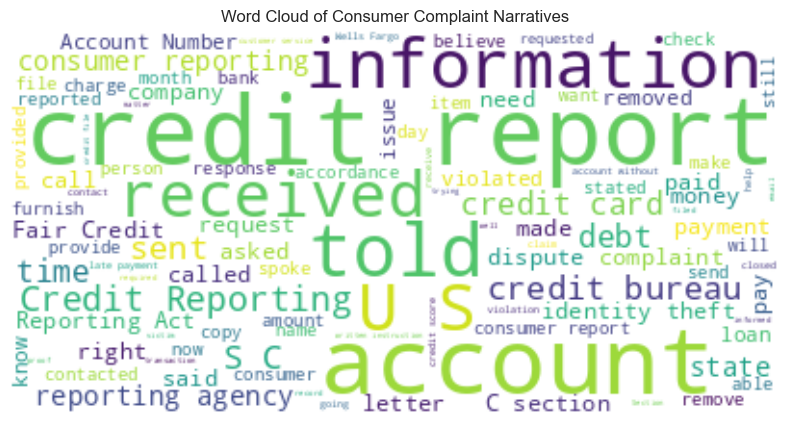

In [100]:

consumer_complaints = data['Consumer complaint narrative'].dropna()  # Remove rows with missing narratives
text = ' '.join(consumer_complaints)  # Combine all narratives into a single text

# Create and generate a word cloud image
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Consumer Complaint Narratives')
plt.show()




topic modeling with LDAModel

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 1:
['00', 'account', 'bank', 'loan', 'payment', 'would', 'card', 'told', 'called', 'money']
Topic 2:
['debt', 'credit', 'information', 'report', 'collection', 'reporting', 'account', 'company', 'letter', 'sent']
Topic 3:
['15', 'consumer', 'section', '1681', 'states', 'reporting', 'agency', 'account', 'privacy', 'furnish']
Topic 4:
['credit', 'report', 'account', 'late', 'reporting', 'inquiries', 'removed', 'information', 'accounts', 'equifax']
Topic 5:
['credit', 'report', 'accounts', 'theft', 'identity', 'items', 'information', '00', 'balance', 'remove']


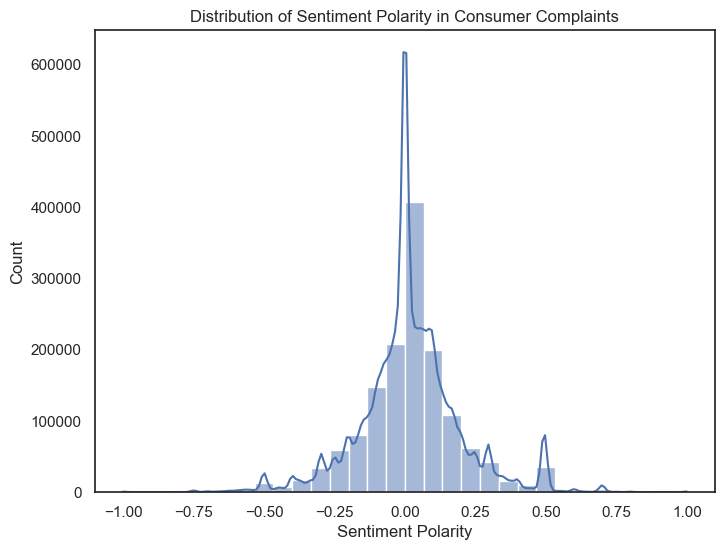

In [102]:
# topic modeling with LDAModel


# Tokenize the text
nltk.download('punkt')
consumer_complaints = consumer_complaints.apply(nltk.word_tokenize)

# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
consumer_complaints = consumer_complaints.apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Convert the tokenized text back to strings
consumer_complaints = consumer_complaints.apply(lambda x: ' '.join(x))

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(consumer_complaints)

# Apply LDA for topic modeling
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topic_matrix = lda_model.fit_transform(tfidf_matrix)


In [121]:

# Visualize topics
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    print(top_words)
    print('\n')



Topic 1:
['00', 'account', 'bank', 'loan', 'payment', 'would', 'card', 'told', 'called', 'money']


Topic 2:
['debt', 'credit', 'information', 'report', 'collection', 'reporting', 'account', 'company', 'letter', 'sent']


Topic 3:
['15', 'consumer', 'section', '1681', 'states', 'reporting', 'agency', 'account', 'privacy', 'furnish']


Topic 4:
['credit', 'report', 'account', 'late', 'reporting', 'inquiries', 'removed', 'information', 'accounts', 'equifax']


Topic 5:
['credit', 'report', 'accounts', 'theft', 'identity', 'items', 'information', '00', 'balance', 'remove']




subset df to customer dispute that is not null

In [125]:
# subset df to customer dispute = not null

df = data[data['Consumer disputed?'].notnull()]

df.shape
df.head()
# check for missing values percentage

df.isnull().sum()/len(df)

df['Consumer disputed?'].value_counts()
df.dtypes
# drop tags column

df.drop('Tags', axis=1, inplace=True)
df.dtypes
# drop ID column

df.drop('Complaint ID', axis=1, inplace=True)
# convert date received and date sent to company to datetime, then create new column for difference in days

"""
Here, for each row in the dataframe, 
the code calculates the difference in days between the date the complaint was sent to the company and the date it was received. 
This difference is then stored in a new column named 'diff_days'.

The purpose of this calculation may be to understand how long it takes, 
on average, for a complaint to be forwarded or processed and sent to the company after it has been received. 
By doing this, one could analyze and get insights on the efficiency of the complaint forwarding process. 
The delay could also have implications on customer satisfaction and the company's responsiveness to issues.
"""

df['diff_days'] = df['Date sent to company'] - df['Date received']

# convert diff_days to int

df['diff_days'] = df['diff_days'].dt.days.astype('int16')


/var/folders/z2/4x1xtsmd40sfmyp2ftrfbkfh0000gn/T/ipykernel_902/4266591194.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Tags', axis=1, inplace=True)
/var/folders/z2/4x1xtsmd40sfmyp2ftrfbkfh0000gn/T/ipykernel_902/4266591194.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Complaint ID', axis=1, inplace=True)
/var/folders/z2/4x1xtsmd40sfmyp2ftrfbkfh0000gn/T/ipykernel_902/4266591194.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [129]:
print(df.shape)

print(df.dtypes)

(768358, 18)
Date received                   datetime64[ns]
Product                                 object
Sub-product                             object
Issue                                   object
Sub-issue                               object
Consumer complaint narrative            object
Company public response                 object
Company                                 object
State                                   object
ZIP code                                object
Consumer consent provided?              object
Submitted via                           object
Date sent to company            datetime64[ns]
Company response to consumer            object
Timely response?                        object
Consumer disputed?                      object
year                                     int64
diff_days                                int16
dtype: object
